## Лабораторная работа по курсу "Искусственный интеллект"
## Многослойный персептрон

| Студент | Ермакова |
|---------|----------|
| Группа  | 301      |

Для начала, скачаем датасет MNIST.

In [1]:
import numpy as np
np.random.seed(0)
import random

In [2]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [4]:
!curl -o mnist.pkl.gz https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9.9M  100  9.9M    0     0  2562k      0  0:00:03  0:00:03 --:--:-- 2561k


In [3]:
!gzip -d mnist.pkl.gz

mnist.pkl already exists -- do you wish to overwrite (y or n)? ^C


Теперь загружаем датасет:

In [5]:
import pickle
with open('mnist.pkl','rb') as f:
    MNIST = pickle.load(f)

In [6]:
labels = MNIST['Train']['Labels']
data = MNIST['Train']['Features'].astype(np.float32) / 256

Смотрим на то, какие данные получились:

In [7]:
data[0].size #каждый элемент - набор 784 пикселя

784

Разбиваем датасет на обучающую и тестовые выборки

In [8]:
n = 42000
train_x, test_x = np.split(data, [n*8//10])
train_labels, test_labels = np.split(labels, [n*8//10])

In [9]:
print(train_x.shape,test_x.shape)

(33600, 784) (8400, 784)


Строим нейросеть

Выделяем отдельные классы для каждого слоя.

In [10]:
class Linear:
    
    def __init__(self,nin,nout): 
        self.W = np.random.normal(0, 1.0/np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1,nout))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        
    def forward(self, x):
        self.x=x
        return np.dot(x, self.W.T) + self.b
    
    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis=0)
        self.dW = dW
        self.db = db
        return dx
    
    def update(self,lr):
        self.W -= lr*self.dW
        self.b -= lr*self.db

In [11]:
class Softmax:
    def forward(self,z):
        self.z = z
        zmax = z.max(axis=1,keepdims=True)
        expz = np.exp(z-zmax)
        Z = expz.sum(axis=1,keepdims=True)
        return expz / Z
    def backward(self,dp):
        p = self.forward(self.z)
        pdp = p * dp
        return pdp - p * pdp.sum(axis=1, keepdims=True)

In [12]:
class CrossEntropyLoss:
    def forward(self,p,y):
        self.p = p
        self.y = y
        p_of_y = []
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y)
        return -log_prob.mean()
    def backward(self,loss):
        dlog_softmax = np.zeros_like(self.p)
        dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0/len(self.y)
        return dlog_softmax / self.p

In [13]:
class Tanh:
    def forward(self,x):
        y = np.tanh(x)
        self.y = y
        return y   
    def backward(self,dy):
        return (1.0-self.y**2)*dy   
    def name(self):
        return 'tanh'

class Sigmoid:
    def forward(self, x):
        y = 1 / (1 + np.exp(-x))
        self.y = y
        return y  
    def backward(self, dy): 
        return self.y*(1.0 - self.y)*dy
    def name(self):
        return 'sigmoid'

class RELU:
    def forward(self,x):
        y = np.maximum(0.0, x)
        self.y = y
        return y
    def backward(self,dy):
        return dy*(self.y>0)
    def name(self):
        return 'RELU'

Опишем класс определяющий сеть

In [14]:
class Net:
    def __init__(self):
        self.layers = []
    
    def add(self,l):
        self.layers.append(l)
        
    def forward(self,x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    def backward(self,z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z
    
    def update(self,lr):
        for l in self.layers:
            if 'update' in l.__dir__():
                l.update(lr)

Выделим классы для алгоритмов обучения

In [15]:
class  Backpropagation:
    def use(self, xb, yb, net, train_x, train_labels, loss, lr ):
        p = net.forward(xb)
        l = loss.forward(p,yb)
        dp = loss.backward(l)
        dx = net.backward(dp)
        net.update(lr)
        
#class  Resilientpropagation:
#    def use(#...):

Создадим класс, удобный для работы с сетью: для этого нам необходимо понять какие основые действия мы с ней производим. 1 - создание сети 2 - обучение модели на датасете 3 - проверка качества модели. В методах класса учтен ввод всевозможных изменяемых параметров, как для создания сети ,так и для ее обучения. Вынесена возможность выбора алгоритма обучения и функции потерь.

In [16]:
class useNet:
    
    # создает сеть в соответствиис введенными параметрами: 
    # массив количества нейронов на каждом слое, функция пормировки, массив функций активации для каждоко слоя.
    def createNet(self, num_neuron_arr, norm_func, act_func):
        net = Net()
        
        for i in np.arange(len(num_neuron_arr)-2):
            net.add(Linear(num_neuron_arr[i],num_neuron_arr[i+1]))
            net.add(act_func[i])
        net.add(Linear(num_neuron_arr[-2],num_neuron_arr[-1]))
       
        net.add(norm_func)
        return net
        
    # создает сеть, которая делает каждый слой полносвязным в соответствиис введенными параметрами: 
    # количество слоев, количество входных и выходных данных, функция пормировки, функция активации.
    def createFullConnectedNet(self, num_layers, nin, nout, norm_func, act_func):
        net = Net()
        if num_layers > 1:
            net.add(Linear(nin,nin))
            net.add(act_func)
            for i in np.arange(num_layers-2):
                net.add(Linear(nin,nin))
                net.add(act_func)
            net.add(Linear(nin,nout))
        else: 
            net.add(Linear(nin,nout))
        net.add(norm_func)
        return net
    
    # обучание на одной эпохе
    def train_epoch(self, algorithm, net, train_x, train_labels, loss, lr):
        for i in range(0,len(train_x),self.batch_size):
            xb = train_x[i:i+self.batch_size]
            yb = train_labels[i:i+self.batch_size]
            
            algorithm.use(xb, yb, net, train_x, train_labels, loss, lr)
      
    # обучение сети ,в качестве параметров принимается:
    # алгоритм обучения, сама сеть, количество эпох, данные_х, данные_у, функция потерь, размар бача и learning rate 
    def train(self, algorithm, net, n_epoch, train_x, train_labels, loss, batch_size, lr):
        self.batch_size = batch_size
        for epoch in range(1, n_epoch + 1):
            self.train_epoch(algorithm, net, train_x, train_labels, loss, lr)
        
    # обучение сети с выводом графика точности, в качестве параметров принимается:
    # алгоритм обучения, сама сеть, количество эпох, данные_х, данные_у, функция потерь, размар бача и learning rate
    def train_and_plot(self, algorithm, net, n_epoch, train_x, train_labels, loss, batch_size, lr):
        self.batch_size = batch_size
        
        acc_train=[]
        loss_train=[]
        epochs = []
        
        for epoch in range(1, n_epoch + 1):
            epochs.append(epoch)
            self.train_epoch(algorithm, net, train_x, train_labels, loss, lr)
            tloss, taccuracy = self.get_loss_acc(net, train_x,train_labels,loss)
            acc_train.append(taccuracy)
            loss_train.append(tloss)

        plt.ylabel('accuracy/loss')
        plt.xlabel('epochs')
        plt.plot(epochs, acc_train, 'r')
        plt.plot(epochs, loss_train, 'g')
        plt.legend({'accuracy', 'loss'})
        plt.show()
        
        p = net.forward(train_x)
        pred = np.argmax(p,axis=1)
        matrix = confusion_matrix(train_labels, pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
        disp.plot()
        plt.show()
        
    # функция, определяющая точнось пресказания, на вход принимает:
    # сеть, данные_х, данные_у, функцию потерь
    def get_loss_acc(self, net, x, y, loss):
        p = net.forward(x)
        l = loss.forward(p,y)
        pred = np.argmax(p,axis=1)
        acc = (pred==y).mean()
        return l, acc
        

Везде в данной работе используется алгоритм - Backpropagation.

№1 - однослойный персепторн

In [17]:
myNet = useNet()
# Используем функцию createFullConnectedNet которая делает каждый слой полносвязным 
net = myNet.createFullConnectedNet(1,784,10,Softmax(), Tanh())

l,acc = myNet.get_loss_acc(net, train_x, train_labels, CrossEntropyLoss())
print("loss={}, accuracy={}: ".format(l,acc)) 
      
myNet.train(Backpropagation(), net, 1, train_x, train_labels, CrossEntropyLoss(), 200, 0.1)

l,acc = myNet.get_loss_acc(net, train_x, train_labels, CrossEntropyLoss())
print("loss={}, accuracy={}: ".format(l,acc)) 
l,acc = myNet.get_loss_acc(net, test_x, test_labels, CrossEntropyLoss())
print("loss={}, accuracy={}: ".format(l,acc)) 

loss=2.404212250000779, accuracy=0.10157738095238095: 
loss=0.5145161235814716, accuracy=0.870297619047619: 
loss=0.510921561455105, accuracy=0.871547619047619: 


Точность больше 0.85 - хватило одной эпохи, подошли параметры: размер батча - 200, learning rate - 0.1, функция нормировки - Softmax, функция активации - tanh, функция ошибки - CrossEntropy.

№2 - многослойный персепторн

Посмотрим точность на разных количествах слоев в полносвязной сети:

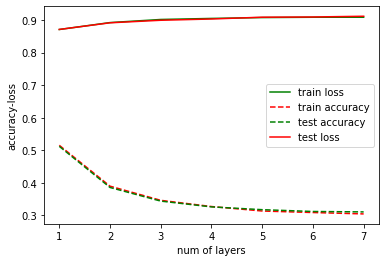

In [18]:
acc_train=[]
acc_test=[]
loss_train=[]
loss_test=[]
ox =[]

for i in np.arange(1,8,1):
    ox.append(i)
    myNet = useNet()
    net = myNet.createFullConnectedNet(i,784,10,Softmax(),Tanh())

    myNet.train(Backpropagation(), net,1,train_x, train_labels, CrossEntropyLoss(), 200, 0.1)
    
    acc_train.append(myNet.get_loss_acc(net,train_x, train_labels, CrossEntropyLoss())[1])
    acc_test.append(myNet.get_loss_acc(net,test_x, test_labels, CrossEntropyLoss())[1])
    loss_train.append(myNet.get_loss_acc(net,train_x, train_labels, CrossEntropyLoss())[0])
    loss_test.append(myNet.get_loss_acc(net,test_x, test_labels, CrossEntropyLoss())[0])
    

plt.ylabel('accuracy-loss')
plt.xlabel('num of layers')
plt.plot(ox, acc_test, 'g')
plt.plot(ox, loss_train, 'r--')
plt.plot(ox, loss_test, 'g--')
plt.plot(ox, acc_train, 'r')
plt.legend({'train loss','train accuracy','test loss','test accuracy'})
plt.show()

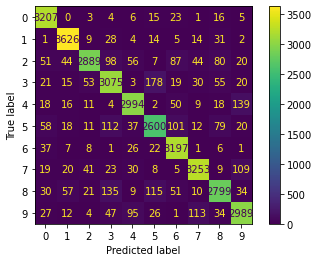

In [19]:
p = net.forward(train_x)
pred = np.argmax(p,axis=1)
matrix = confusion_matrix(train_labels, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()
plt.show()

Точность больше 0.85 - хватило одной эпохи, подошли параметры: размер батча - 200, learning rate - 0.1, функция нормировки - Softmax, функция активации - tanh, функция ошибки - CrossEntropy.

№3.1 Рассмотрим различные функции активации:

в качестве начальных параметров выберем двухслойную сеть и параметры : размер батча - 200, количество эпох - 5, learning rate - 0.1, функция нормировки - Softmax, функция ошибки - CrossEntropy

Функции активации нейросети: сигмоида, ReLu, tahn

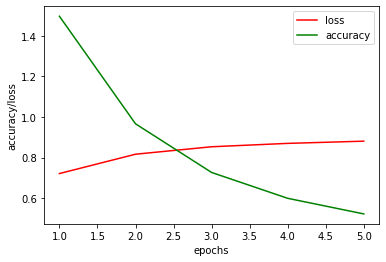

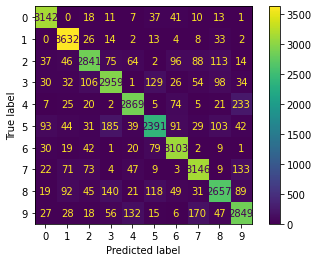

sigmoid: for test: loss=0.5182449821733516, accuracy=0.883095238095238: 


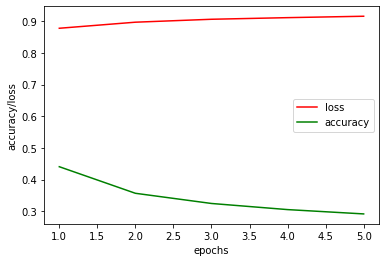

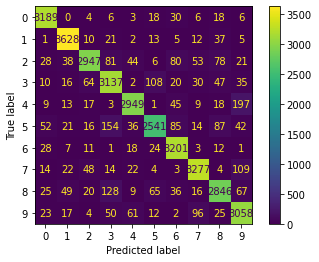

RELU: for test: loss=0.2983599297683115, accuracy=0.9144047619047619: 


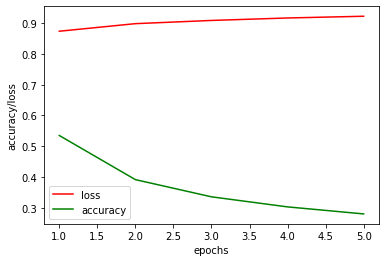

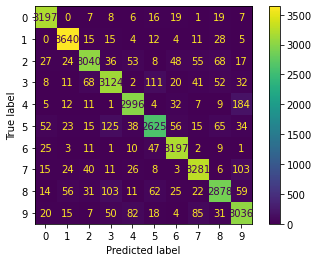

tanh: for test: loss=0.2846885567134234, accuracy=0.9202380952380952: 


In [20]:
act_func_arr = [Sigmoid(),RELU(),Tanh()]

for func in act_func_arr:
    myNet = useNet()

    arr_neurons = [784,20,10]
    arr_act_funcs = [func]

    net = myNet.createNet(arr_neurons,Softmax(),arr_act_funcs)

    myNet.train_and_plot(Backpropagation(), net, 5, train_x, train_labels, CrossEntropyLoss(), 200, 0.1)

    l,acc = myNet.get_loss_acc(net, test_x, test_labels, CrossEntropyLoss())
    print(func.name() + ": for test: loss={}, accuracy={}: ".format(l,acc)) 

Наглядно видно, что разные функции активации дают разную точность классификации, в данном случае RELU и tanh дали примерно одинаковый результат accuracy (0.91 и 0.92 на тестовой соответственно), в то время как sigmoid оказался хуже (0.88 на тестовой) 

№3.2 Попробуем использовать различное число нейронов в промежуточном слое, рассмотрим двухслойный персептрон:

в качестве начальных параметров выберем двухслойную сеть и параметры : размер батча - 200, количество эпох - 1, learning rate - 0.1, функция нормировки - Softmax, функция ошибки - CrossEntropy, функция активации - Tanh

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

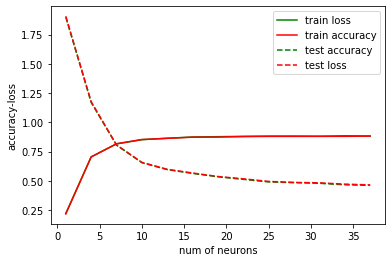

In [22]:
acc_train=[]
acc_test=[]
loss_train=[]
loss_test=[]
ox =[]

for i in np.arange(1,40,3):
    ox.append(i)
    myNet = useNet()
    arr_neurons = [784,i,10]
    arr_act_funcs = [Tanh()]
    net = myNet.createNet(arr_neurons,Softmax(),arr_act_funcs)

    myNet.train(Backpropagation(), net,1,train_x, train_labels, CrossEntropyLoss(), 200, 0.1)
    
    acc_train.append(myNet.get_loss_acc(net,train_x, train_labels, CrossEntropyLoss())[1])
    acc_test.append(myNet.get_loss_acc(net,test_x, test_labels, CrossEntropyLoss())[1])
    loss_train.append(myNet.get_loss_acc(net,train_x, train_labels, CrossEntropyLoss())[0])
    loss_test.append(myNet.get_loss_acc(net,test_x, test_labels, CrossEntropyLoss())[0])
    

plt.ylabel('accuracy-loss')
plt.xlabel('num of neurons')
plt.plot(ox, acc_test, 'g')
plt.plot(ox, acc_train, 'r')
plt.plot(ox, loss_test, 'g--')
plt.plot(ox, loss_train, 'r--')
plt.legend({'train accuracy','test accuracy','train loss','test loss'})
plt.show()

В результате лучшие значеня при количестве нейронов больше 10.

Реализация четырехслойного персептрона с функцией активации - Tanh и количеством нейронов на каждом скрытом уровне - 20. 

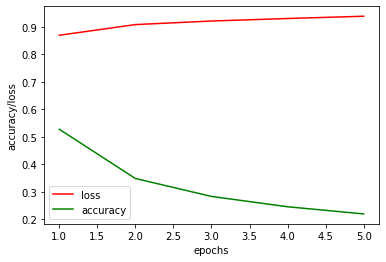

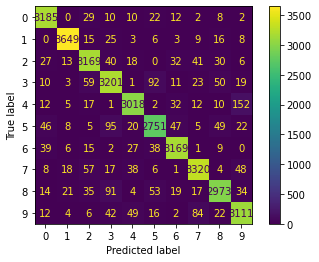

for test: loss=0.23613708088189883, accuracy=0.9297619047619048: 


In [23]:
myNet = useNet()

arr_neurons = [784,20,20,20,10]
arr_act_funcs = [Tanh(),Tanh(),Tanh()]

net = myNet.createNet(arr_neurons,Softmax(),arr_act_funcs)

myNet.train_and_plot(Backpropagation(), net, 5, train_x, train_labels, CrossEntropyLoss(), 200, 0.1)

l,acc = myNet.get_loss_acc(net, test_x, test_labels, CrossEntropyLoss())
print("for test: loss={}, accuracy={}: ".format(l,acc)) 

In [24]:
import tensorflow as tf

In [33]:
(train_X, train_Labels), (test_X, test_Labels) = tf.keras.datasets.fashion_mnist.load_data()

train_X = train_X.reshape((60000, 784))
test_X = test_X.reshape((10000, 784))
train_X = train_X / 255.0
test_X = test_X / 255.0

print(train_X.shape, test_X.shape)

(60000, 784) (10000, 784)


In [34]:
import numpy

In [35]:
numpy.unique(test_Labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

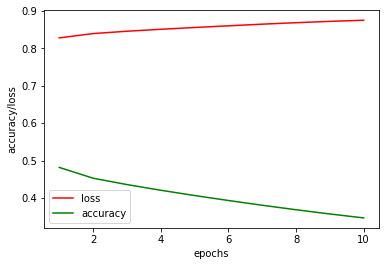

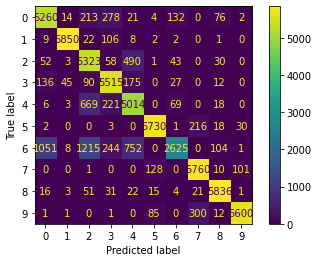

train: loss=0.3464654604889062, accuracy=0.8752166666666666: 
test: loss=0.4105419332634286, accuracy=0.8566: 


In [39]:
myNet = useNet()

arr_neurons = [784,784,784,10]
arr_act_funcs = [Tanh(),Tanh()]

net = myNet.createNet(arr_neurons,Softmax(),arr_act_funcs)

myNet.train_and_plot(Backpropagation(), net, 10, train_X, train_Labels, CrossEntropyLoss(), 150, 0.1)

l,acc = myNet.get_loss_acc(net, train_X, train_Labels, CrossEntropyLoss())
print("train: loss={}, accuracy={}: ".format(l,acc)) 
l,acc = myNet.get_loss_acc(net, test_X, test_Labels, CrossEntropyLoss())
print("test: loss={}, accuracy={}: ".format(l,acc)) 